In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.layers import Input


In [5]:
disease_types = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
                         'Tomato_Bacterial_spot', 'Tomato_Early_blight',
                         'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                         'Tomato__Target_Spot',
                         'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
data_dir = 'PlantVillage/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [6]:
import os

train_data = []
for defects_id, sp in enumerate(disease_types):
    subdir_path = os.path.join(train_dir, sp)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            train_data.append([os.path.join(sp, file), defects_id, sp])
    else:
        print(f"The directory '{subdir_path}' does not exist.")
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])


In [7]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy\9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy
1,Potato___Early_blight\900514b4-8768-4370-bc53-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot\dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy\e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy
4,Tomato_Leaf_Mold\2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold


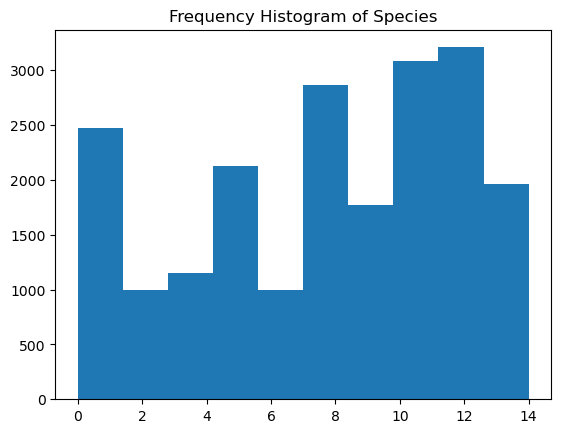

<Figure size 1200x1200 with 0 Axes>

In [8]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

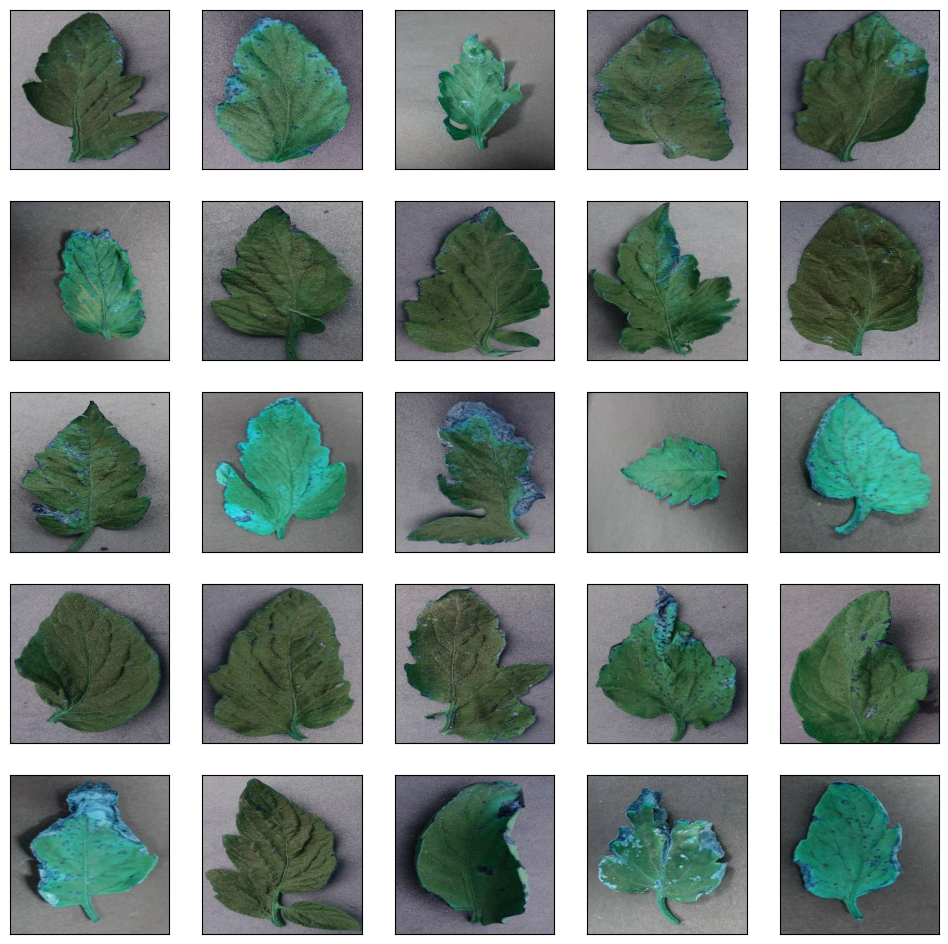

In [9]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [10]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [03:50, 89.55it/s] 


Train Shape: (20639, 64, 64, 3)


In [13]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [14]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

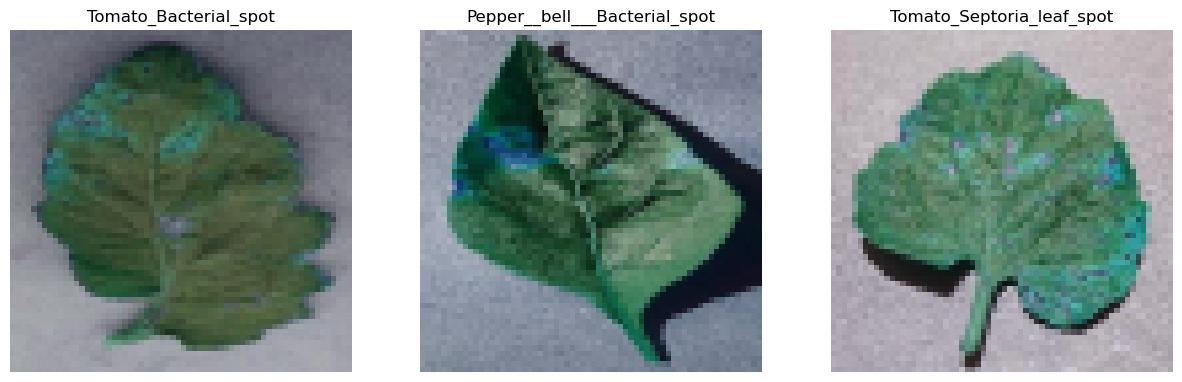

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [16]:
EPOCHS = 25
SIZE=64
N_ch=3

In [17]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [18]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,308,963 (27.88 MB)

 Trainable params: 7,222,755 (27.55 MB)

 Non-trainable params: 86,208 (336.75 KB)

Epoch 1/25


C:\Users\Fouss\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.95689, saving model to model.keras
257/257 - 956s - 4s/step - accuracy: 0.3129 - loss: 2.5941 - val_accuracy: 0.4658 - val_loss: 1.9569 - learning_rate: 0.0020
Epoch 2/25


C:\Users\Fouss\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.95689 to 1.92744, saving model to model.keras
257/257 - 49s - 190ms/step - accuracy: 0.5000 - loss: 1.6413 - val_accuracy: 0.4697 - val_loss: 1.9274 - learning_rate: 0.0020
Epoch 3/25

Epoch 3: val_loss improved from 1.92744 to 0.91552, saving model to model.keras
257/257 - 813s - 3s/step - accuracy: 0.6657 - loss: 1.0675 - val_accuracy: 0.7180 - val_loss: 0.9155 - learning_rate: 0.0020
Epoch 4/25

Epoch 4: val_loss did not improve from 0.91552
257/257 - 46s - 180ms/step - accuracy: 0.7031 - loss: 0.7294 - val_accuracy: 0.7151 - val_loss: 0.9261 - learning_rate: 0.0020
Epoch 5/25

Epoch 5: val_loss improved from 0.91552 to 0.56699, saving model to model.keras
257/257 - 879s - 3s/step - accuracy: 0.8083 - loss: 0.6041 - val_accuracy: 0.8149 - val_loss: 0.5670 - learning_rate: 0.0020
Epoch 6/25

Epoch 6: val_loss improved from 0.56699 to 0.54485, saving model to model.keras
257/257 - 48s - 189ms/step - accuracy: 0.8906 - loss: 0.4601 - val_accuracy: 0.8

In [19]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - accuracy: 0.9025 - loss: 0.3588
Final Loss: 0.30673354864120483, Final Accuracy: 0.9161821603775024


129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 346ms/step


Text(0.5, 192.58159722222217, 'Predicted')

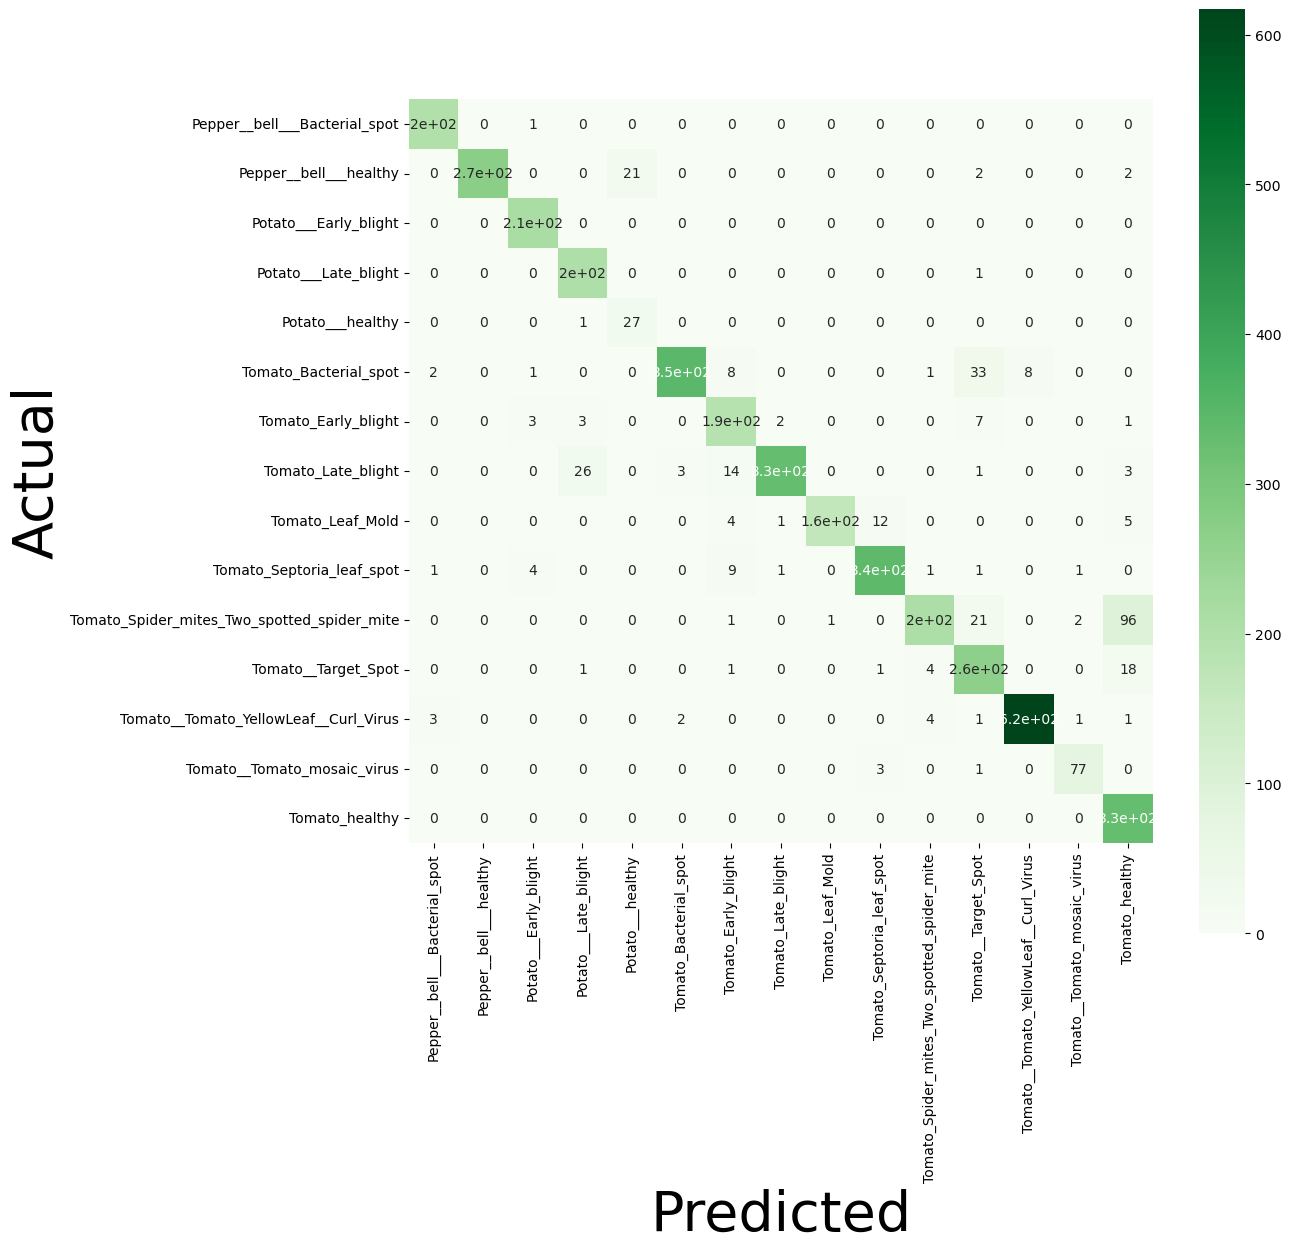

In [20]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

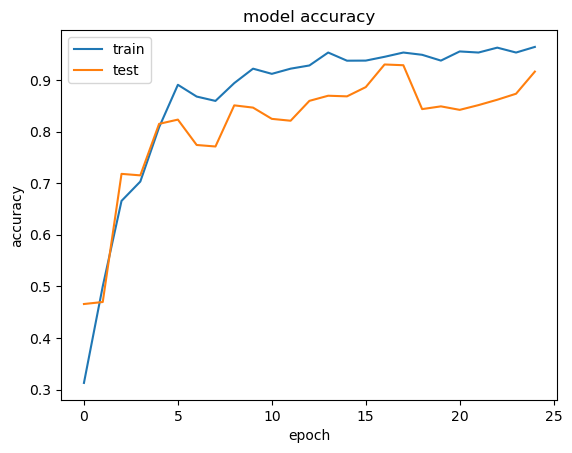

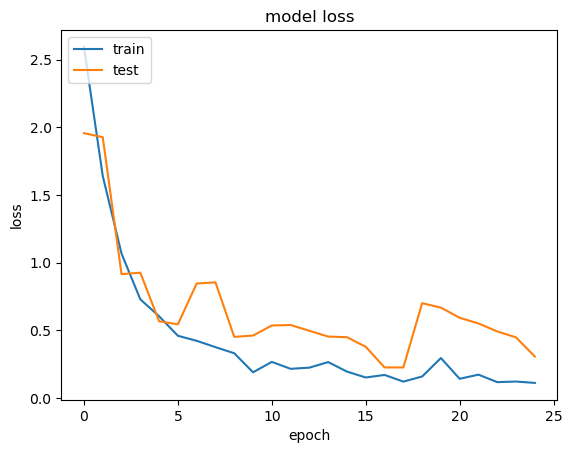

In [26]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[3.3322439e-02 9.5968497e-01 5.9737638e-04 2.0111755e-05 2.0932409e-03
 1.0781200e-06 1.6622455e-03 6.9619323e-06 2.8874494e-05 1.5569947e-04
 6.1074711e-06 2.0249002e-03 1.0221911e-06 9.8161043e-05 2.9686600e-04]


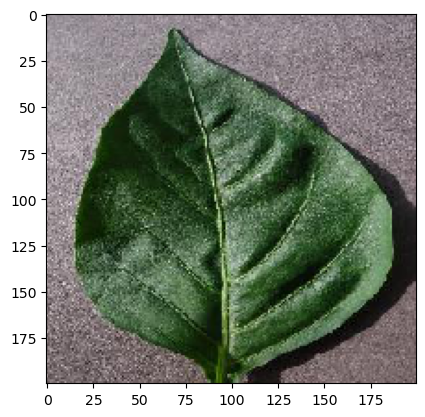

Prediction: Pepper__bell___healthy


In [28]:
from skimage import io
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Chargement de l'image
img = image.load_img('PlantVillage/Pepper__bell___healthy/0a3f2927-4410-46a3-bfda-5f4769a5aaf8___JR_HL 8275.JPG', target_size=(64, 64))
show_img = image.load_img('PlantVillage/Pepper__bell___healthy/0dd09705-5593-4d01-9a9b-c1d5857daf92___JR_HL 8212.JPG', target_size=(200, 200))

# Liste des classes de maladies
disease_class =['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
                         'Tomato_Bacterial_spot', 'Tomato_Early_blight',
                         'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                         'Tomato__Target_Spot',
                         'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
# Conversion de l'image en tableau numpy et normalisation
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

# Prédiction avec le modèle
custom = model.predict(x)
print(custom[0])

# Affichage de l'image
plt.imshow(show_img)
plt.show()

# Récupération de la classe prédite
a = custom[0]
ind = np.argmax(a)
print('Prediction:', disease_class[ind])


